In [1]:
import numpy as np
from scipy import linalg as la
from sklearn.base import BaseEstimator
from scipy.stats import multivariate_normal as mn
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris
import os
from scipy.misc import imread
from matplotlib import pyplot as plt

Code up the EM algorithm for GMM and apply it to the datasets you used on your K-means lab (iris, earthquakes, and color-quantization). Compare the GMM results to the K-means results. Discuss

In [55]:
# Code up EM algorithm
class GMM(BaseEstimator) :
    '''
    A basic GMM classifier
    '''
    def __init__(self,K) :
        self.K = K
        self.π = np.random.random(K)
        self.π /= la.norm(self.π)
    
    def fit(self,X,y=None) :
        self.N = X.shape[0]
        self.μ = X[np.random.choice(range(self.N),size=self.K),:]
        μ_old = self.μ
        self.Σ = [np.cov(X.T)]*self.K
        self.r = np.zeros((self.N,self.K))
        num_iters = 0
        while num_iters < 100 and la.norm(np.array([μ_old[i]-self.μ[i] for i in range(len(self.μ))])) > 1e-5 :
            μ_old = self.μ
            # E step
            for i in range(self.K) :
                self.r[:,i] = self.π[i]*mn.pdf(X,mean=self.μ[i],cov=self.Σ[i])
            for i in range(self.N) :
                self.r[i,:] = self.r[i,:]/sum(self.r[i,:])
            # M step
            self.π = [sum(self.r[:,i])/self.N for i in range(self.K)]
            for i in range(self.K) :
                self.μ[i] = sum([(X[j,:]*self.r[j,i]) for j in range(self.N)])/(self.N*self.π[i])
                self.Σ[i] = sum([self.r[j,i]*(X[j,:]-self.μ[i]).dot((X[j,:]-self.μ[i]).T)  for j in range(self.N)])/(self.π[i]*self.N)
            num_iters += 1
        return self
    
    def predict(self,X) :
        self.fit(X)
        res = np.array([np.argmax(self.r[i,:]) for i in range(self.N)])
        return res

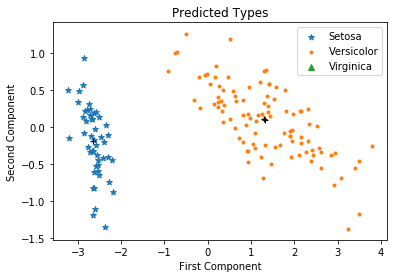

In [41]:
# Apply it to iris dataset
# Load data
iris = load_iris()
X = iris.data
Y = X - X.mean(axis=0)
# PCA through SVD
U,S,VT = la.svd(Y, full_matrices=False)
l = 2
Y_hat = np.dot(Y,VT.T[:,:l])
gmm = GMM(K=3)
res = gmm.predict(Y_hat)
# Plot results
colors = ['g','c','r']
plt.title('Predicted Types')
plt.xlabel('First Component')
plt.ylabel('Second Component')
plt.scatter(Y_hat[res==0,0],Y_hat[res==0,1],marker='*',label='Setosa')
plt.scatter(Y_hat[res==1,0],Y_hat[res==1,1],marker='.',label='Versicolor')
plt.scatter(Y_hat[res==2,0],Y_hat[res==2,1],marker='^',label='Virginica')
for i in range(len(gmm.μ)) :
    plt.plot(gmm.μ[i][0],gmm.μ[i][1],c='k',marker='+')
plt.legend()
plt.show()

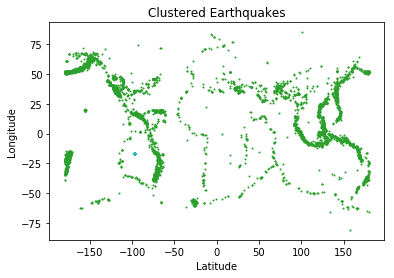

In [43]:
# Apply it to earthquakes dataset
path = '../../KMeansClustering/'
earth = np.load(path+'earthquake_coordinates.npy')
# Switch to radians
rad_coords = np.zeros_like(earth)
rad_coords[:,0] = np.pi/180*earth[:,0]
rad_coords[:,1] = np.pi/180*(90-earth[:,1])
# Switch to spherical
sphr_coords = np.zeros((rad_coords.shape[0],3))
sphr_coords[:,0] = np.ones_like(rad_coords[:,0])
sphr_coords[:,1] = rad_coords[:,1]
sphr_coords[:,2] = rad_coords[:,0]
# Switch to rectangular
rect_coords = np.zeros_like(sphr_coords)
rect_coords[:,0] = sphr_coords[:,0]*np.sin(sphr_coords[:,2])*np.cos(sphr_coords[:,1])
rect_coords[:,1] = sphr_coords[:,0]*np.sin(sphr_coords[:,2])*np.sin(sphr_coords[:,1])
rect_coords[:,2] = sphr_coords[:,0]*np.cos(sphr_coords[:,2])
# Run GMM
earth_means = GMM(K=15)
res = earth_means.predict(rect_coords)
# Get means in rectangular coordinates
rect_means = earth_means.μ
# Convert to spherical
sphr_means = np.zeros_like(rect_means)
sphr_means[:,0] = np.ones_like(rect_means[:,0])
sphr_means[:,1] = np.arctan2(rect_means[:,1],rect_means[:,0])
sphr_means[:,2] = np.arccos(rect_means[:,2])
# Convert to latitude-longitude
lat_long_means = np.zeros((sphr_means.shape[0],2))
for i in range(lat_long_means.shape[0]) :
    lat_long_means[i,1] = 90 - 180/np.pi*sphr_means[i,2]
    lat_long_means[i,0] = 180/np.pi*sphr_means[i,1]
# Plot
for i in range(15) :
    plt.scatter(earth[res == i,0],earth[res == i,1],s=1)
    plt.scatter(lat_long_means[i,0],lat_long_means[i,1],marker='+',s=15)
plt.title('Clustered Earthquakes')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()

In [48]:
# Apply it to color-quantization dataset
def quantize_image(im, K=4, n_samples=50):
    """Cluster the pixels of the image 'im' by color.
    Return a copy of the image where each pixel is replaced by the value
    of its cluster center.
    
    Parameters:
        im ((m,n,3) ndarray): an image array.
        n_clusters (int): the number of k-means clusters.
        n_samples (int): the number of pixels to train the k-means model on.
    
    Returns:
        ((m,n,3) ndarray): the quantized image.
    """
    # Get shapes
    m,n,r = im.shape
    # Create new array for image in rgb space
    rgb_im = im.reshape(-1,r)
    # Get pixels for trainint
    pixels = np.random.randint(0,m*n,n_samples)
    X = rgb_im[pixels,:]
    # Run kmeans
    gmm = GMM(K=K)
    res = gmm.predict(rgb_im)
    # Get cluster centers
    cents = gmm.μ
    # Create flattened image where each pixel is the color of it's center
    new_im = np.copy(rgb_im)
    for j in range(m*n) :
        new_im[j,:] = cents[res[j],:]
    # Final matrix (reshape it)
    return new_im.reshape(m,n,r)

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:6: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


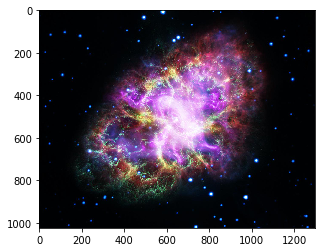

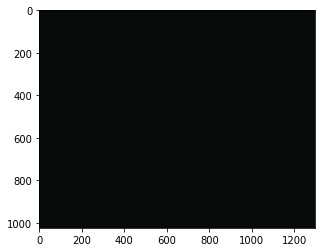

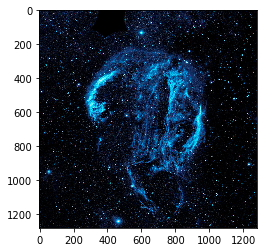

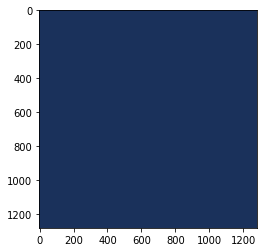

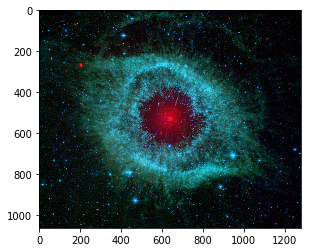

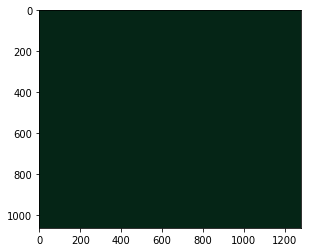

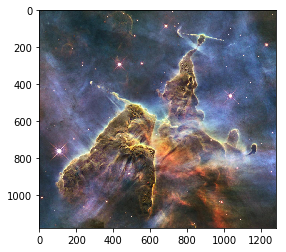

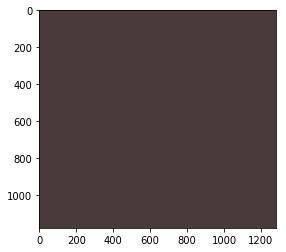

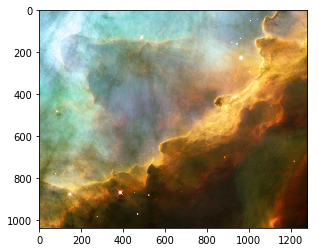

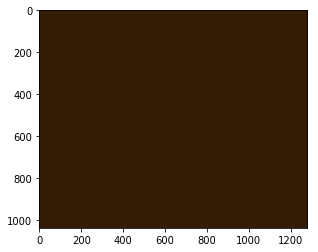

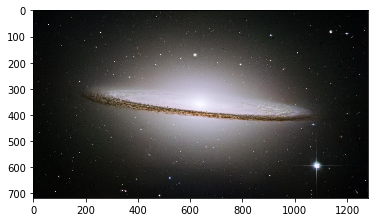

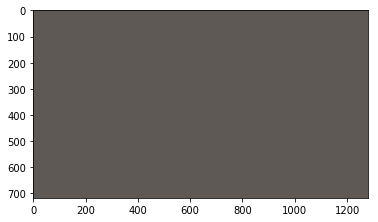

In [56]:
photos = []
# Go through all photos
for dir_path, direct, filename in os.walk(path+'nasa') :
    for file in filename :
        # Put them in a list
        photos.append(imread(str(dir_path)+'/'+str(file)))
# Display photo and quantized photo... Something went horrible wrong.
for photo in photos :
    plt.imshow(photo)
    plt.show()
    plt.imshow(quantize_image(photo))
    plt.show()

(Compare and discuss here.)